## **EDA**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

df = pd.read_csv('marketing_AB.csv', low_memory=False)
display(df.head())

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


### **Описание датасета**

Датасет содержит 588 101 строку, 7 признаков. В нем представлены результаты маркетингового A/B-теста, проведенного с целью оценки эффективности рекламной кампании. Пользователи были случайным образом разделены на контрольную и тестовую группы: часть пользователей видела рекламные объявления, другая — альтернативный контент без рекламы.

Основная задача эксперимента — определить, приводит ли показ рекламы к увеличению конверсии, оценив статистическую значимость различий между группами. Это позволит сделать вывод о целесообразности запуска рекламной кампании.

### **Описание признаков**

- **Unnamed: 0** — порядковый номер строки в датасете, не используется в анализе
(тип: int64, формат: целое неотрицательное число)

- **user_id** — уникальный идентификатор пользователя, используется как единица наблюдения и для проверки дубликатов
(тип: int, формат: целое число)

- **test_group** — группа A/B-теста: ad — пользователь видел рекламное объявление (тестовая), psa — пользователь видел PSA или не видел рекламу (контрольная)
(тип: string, формат: ad | psa)

- **converted** — флаг совершения покупки пользователем
(тип: boolean, формат: True | False)

- **total_ads** — общее количество рекламных показов, увиденных пользователем за период эксперимента
(тип: int, формат: целое неотрицательное число)

- **most_ads_day** — день недели, в который пользователь увидел наибольшее количество рекламных показов
(тип: string, формат: Monday–Sunday)

- **most_ads_hour** — час суток, в который пользователь увидел наибольшее количество рекламных показов
(тип: int,
 формат: число от 0 до 23)

### **Очистка данных**

In [9]:
# Количество пропусков по каждому столбцу
df.isna().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


In [10]:
# Количество дублирующихся строк
df.duplicated().sum()

np.int64(0)

In [11]:
df = df.drop(columns=['Unnamed: 0']) # Удаление ненужного столбца
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [12]:
df['converted'] = df['converted'].astype(int) # Приведение к целочисленному типу

Пропуски и дублирующие строки отстутсвуют. Ненужный столбец был удален, признак **converted** был приведен к целочисленному типу для дальнейшего анализа.

### **Визуализация конверсии**

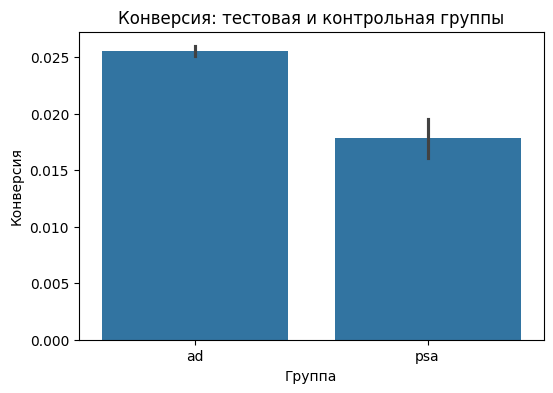

In [15]:
# Конверсия по группам
plt.figure(figsize=(6,4))
sns.barplot(data=df, x='test group', y='converted')
plt.title("Конверсия: тестовая и контрольная группы")
plt.xlabel("Группа")
plt.ylabel("Конверсия")
plt.show()


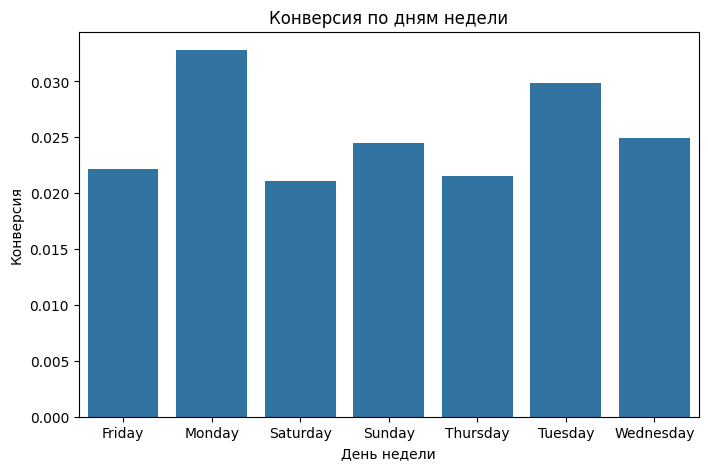

In [ ]:
# Конверсия по дням недели
day_rate = df.groupby('most ads day')['converted'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=day_rate, x='most ads day', y='converted')
plt.title("Конверсия по дням недели")
plt.xlabel("День недели")
plt.ylabel("Конверсия")
plt.show()


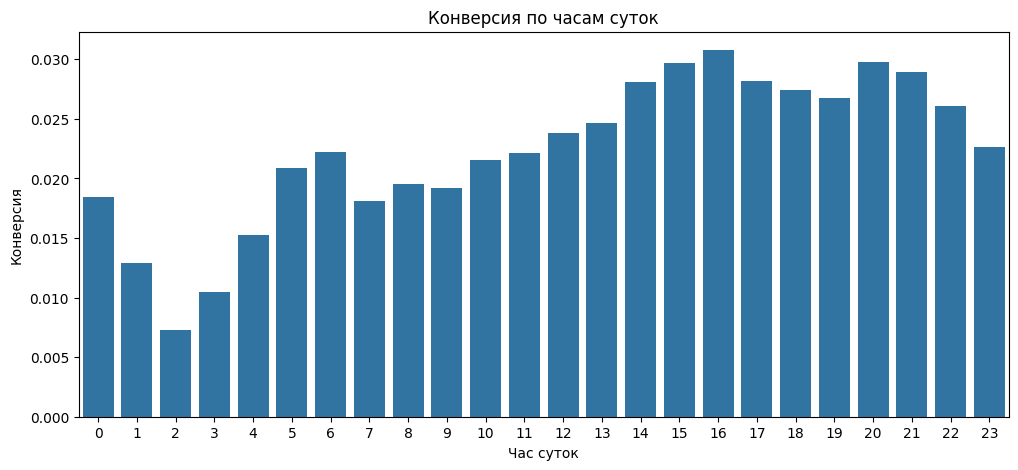

In [ ]:
# Конверсия по часам
hour_rate = df.groupby('most ads hour')['converted'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.barplot(data=hour_rate, x='most ads hour', y='converted')
plt.title("Конверсия по часам суток")
plt.xlabel("Час суток")
plt.ylabel("Конверсия")
plt.show()


На графиках видно, что конверсия в тестовой группе (с рекламой) заметно выше, чем в контрольной группе: около 2,6% против 1,7–1,8%, из чего можно сформулировать гипотезу об эффективности маркетинговой кампании. В разрезе дней недели максимальная конверсия наблюдается в понедельник и вторник, тогда как минимальные значения приходятся на субботу и четверг. По часам суток конверсия минимальна ночью, с самым низким значением около 0,7–1,0% в 2–3 часа, затем постепенно растет и достигает пика днем и во второй половине дня — максимальные значения около 3,0–3,1% в интервале 15–16 часов, после чего к вечеру и ночи снова снижается до примерно 2,2–2,6%.

## **A/B-тестирование**

In [ ]:
# Разделяем на тестовую и контрольную группы
treatment = df[df['test group'] == 'ad']
control = df[df['test group'] == 'psa']

print(f'Доля тестовой выборки от всех данных: {np.round(len(treatment) / len(df), 2)}')
print(f'Доля контрольной выборки от всех данных: {np.round(len(control) / len(df), 2)}')


Доля тестовой выборки от всех данных: 0.96
Доля контрольной выборки от всех данных: 0.04


Экспериментальные группы сильно несбалансированы: около 96% пользователей находятся в тестовой группе и около 4% — в контрольной, поэтому при анализе результатов необходимо учитывать меньший размер контрольной группы.

Тестовая группа имеет долю конверсии на 0,8-0,9 п.п. выше контрольной, из чего строим гипотезу о значимости кампании.

$H_0 -$ конверсия в группе с рекламой не отличается от конверсии в контрольной группе.

$H_1 -$ конверсия в группе с рекламой выше, чем в контрольной группе.

Проверим гипотезу с помощью z-критерия.

In [ ]:
# Число конверсий и размер выборок
success_t = treatment['converted'].sum()
nobs_t = len(treatment)

success_c = control['converted'].sum()
nobs_c = len(control)

# z-test
z_stat, p_value = proportions_ztest([success_t, success_c], [nobs_t, nobs_c], alternative='larger')

print("z-статистика:", z_stat)
print("p-value:", p_value)

z-статистика: 7.3700781265454145
p-value: 8.526403580779863e-14


**Вывод:** При $α = 0,5$ отвергаем $H_0$, так как $p-value < α$. Конверсия в группе с рекламой статистически значимо выше, чем в контрольной. Следовательно, в данном случае рекламу можно рекомендовать к использованию.